In [91]:
import numpy as np
import pandas as pd
import time
import importlib

import scripts.local_environment as local
importlib.reload(local);

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
%%time
df = pd.read_csv('data/clean/train_clean.csv')
df_targets = pd.read_csv('data/clean/train_labels.csv')
df_test = pd.read_csv('data/clean/test_clean.csv')

CPU times: user 1min 35s, sys: 8.02 s, total: 1min 43s
Wall time: 1min 44s


### Experimento 3
Entrenamiento con el mes de Mayo/2016 con sólo clientes antiguos

In [ ]:
x_train = df[df['fecha_dato'] == '2016-05-28']
y_train = df_targets.loc[x_train.index]

In [5]:
ncodpers_both_month = list(set(x_train['ncodpers'].values) & set(df_test['ncodpers'].values))
len(ncodpers_both_month)

699690

In [6]:
x = x_train[x_train['ncodpers'].isin(ncodpers_both_month)].drop(['fecha_dato', 'fecha_alta'], axis=1)
y = y_train.loc[x.index].as_matrix()
x = x.as_matrix()

In [7]:
%%time
rf = local.model(x, y, RandomForestClassifier(n_jobs=4))

CPU times: user 2min 49s, sys: 8.8 s, total: 2min 57s
Wall time: 53.2 s


In [8]:
x_test = df_test.drop(['fecha_dato', 'fecha_alta'], axis=1).as_matrix()

In [9]:
%%time
probs, preds = local.calculatePredsProbs(x_test, rf)

CPU times: user 2min 17s, sys: 4.58 s, total: 2min 22s
Wall time: 1min 5s


In [10]:
%%time
subm = local.processPredictions(probs=probs, preds=preds, df_train=x_train, df_test=df_test,
                                df_targets=y_train, env='submit')

change
results/submissions/2018-07-13-h12-05-59_submission.csv
CPU times: user 16.7 s, sys: 836 ms, total: 17.5 s
Wall time: 18.7 s


### Experimento 4
Entrenamiento con Mayo 2016 y todos los clientes

In [17]:
x_train = df[df['fecha_dato'] == '2016-05-28']
y_train = df_targets.loc[x_train.index]

x = x_train.drop(['fecha_dato', 'fecha_alta'], axis=1)
y = y_train.loc[x.index].as_matrix()
x = x.as_matrix()

In [18]:
%%time
rf = local.model(x, y, RandomForestClassifier(n_jobs=4))

CPU times: user 3min 26s, sys: 14.6 s, total: 3min 40s
Wall time: 1min 17s


In [19]:
x_test = df_test.drop(['fecha_dato', 'fecha_alta'], axis=1).as_matrix()

In [20]:
%%time
probs, preds = local.calculatePredsProbs(x_test, rf)

CPU times: user 3min 9s, sys: 6.43 s, total: 3min 15s
Wall time: 1min 34s


In [21]:
%%time
subm, name_file = local.processPredictions(probs=probs, preds=preds, df_train=x_train, df_test=df_test,
                                df_targets=y_train, env='submit')

change
results/submissions/2018-07-13-h13-52-03_submission.csv
CPU times: user 18.3 s, sys: 1.04 s, total: 19.3 s
Wall time: 20.4 s


### Experimento 5
Entrenamiento con Junio 2015 - todos los clientes

In [11]:
x_train = df[df['fecha_dato'] == '2015-06-28']
y_train = df_targets.loc[x_train.index]

In [12]:
x = x_train.drop(['fecha_dato', 'fecha_alta'], axis=1)
y = y_train.loc[x.index].as_matrix()
x = x.as_matrix()

In [13]:
%%time
rf = local.model(x, y, RandomForestClassifier(n_jobs=4))

CPU times: user 2min, sys: 7.36 s, total: 2min 7s
Wall time: 39 s


In [14]:
x_test = df_test.drop(['fecha_dato', 'fecha_alta'], axis=1).as_matrix()

In [15]:
%%time
probs, preds = local.calculatePredsProbs(x_test, rf)

CPU times: user 2min 16s, sys: 4.77 s, total: 2min 20s
Wall time: 1min 4s


In [16]:
%%time
subm, name_file = local.processPredictions(probs=probs, preds=preds, df_train=x_train, df_test=df_test,
                                df_targets=y_train, env='submit')

change
results/submissions/2018-07-13-h12-11-56_submission.csv
CPU times: user 16.5 s, sys: 428 ms, total: 17 s
Wall time: 18.1 s


### Experimento 6
Entrenamiento progresivo individual
Esta prueba será *local* para predecir los productos del mes de Mayo/2016

In [4]:
dates = df.fecha_dato.unique()
date_test = dates[-1]

In [8]:
results = pd.DataFrame(columns=['date', 'score', 'amount_data'])

for i, date in enumerate(dates[:-1]):
    df_x = df[df['fecha_dato'] == date]
    df_y = df_targets.loc[df_x.index]
    
    x_train = df_x.drop(['fecha_dato', 'fecha_alta'], axis=1).as_matrix()
    y_train = df_y.as_matrix()
    
    df_x_test = df[df['fecha_dato'] == date_test].drop(['fecha_dato', 'fecha_alta'], axis=1)
    df_y_test = df_targets.loc[df_x_test.index]
    
    x_test = df_x_test.as_matrix()
    y_test = df_y_test.as_matrix()
    
    model = local.model(x_train, y_train, RandomForestClassifier(n_jobs=4))
    probs, preds = local.calculatePredsProbs(x_test, model)
    
    df_prev = df[df['fecha_dato'] == dates[-2]]
    df_y = df_targets.loc[df_prev.index]
    
    predicted, actual = local.processPredictions(probs, preds, df_prev, df_x_test, df_y, df_y_test)
    
    score = local.mapk(actual, predicted, 7)
    
    results.loc[i] = [date, score, x_train.shape[0]]
    print(date)

#### Resultados

In [5]:
res_exp6 = pd.read_csv('scripts/results/experiment6.csv')
res_exp6['date'] = dates[:-1]

In [6]:
res_exp6.head()

,date,score,amount_data
0,2015-01-28,0.013998,513791.0
1,2015-02-28,0.014096,516199.0
2,2015-03-28,0.014225,518439.0
3,2015-04-28,0.014149,520048.0
4,2015-05-28,0.014164,522000.0


In [7]:
validation = pd.read_csv('utils/max_scoresv2.csv')
max_score = validation[validation['fecha'] == '2016-05-28'].iloc[:, -1].values

In [8]:
dates_exp6 = res_exp6['date'].values
scores_exp6 = res_exp6['score'].values

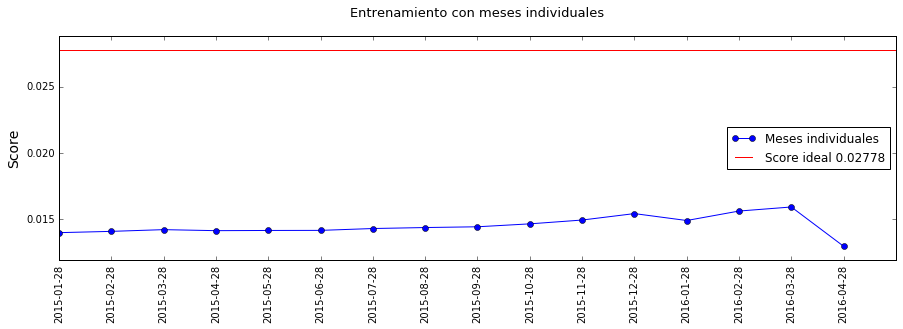

In [58]:
plt.figure(figsize=(15, 4))
plt.plot(scores_exp6, '-o')
plt.axhline(max_score[0], color='r', )
plt.ylim(scores_exp6.min() - 0.001, max_score[0]+0.001)
plt.xticks(range(len(dates_exp6)), dates_exp6, rotation=90)
#for i, val in enumerate(amount_data):
#    plt.text(i, score[i]+0.001, val, ha='left')
plt.title('Entrenamiento con meses individuales\n', size=13)
plt.ylabel('Score', size=14)
plt.legend(['Meses individuales', 'Score ideal ' + '{:.5f}'.format(max_score[0])], loc=0)

### Experimento 7
Entrenamiento progresivo acumulado.
* **Test:** Mayo 2016
* **Env:** local

In [ ]:
dates = df.fecha_dato.unique()
date_test = dates[-1]

results = pd.DataFrame(columns=['date_start', 'date_end', 'score', 'amount_data'])

for i in range(1, len(dates[:-1])+1):
    date_range = dates[:i]
    df_x = df[df['fecha_dato'].isin(date_range)]
    df_y = df_targets.loc[df_x.index]
    
    x_train = df_x.drop(['fecha_dato', 'fecha_alta'], axis=1).as_matrix()
    y_train = df_y.as_matrix()
    
    df_x_test = df[df['fecha_dato'] == date_test].drop(['fecha_dato', 'fecha_alta'], axis=1)
    df_y_test = df_targets.loc[df_x_test.index]
    
    x_test = df_x_test.as_matrix()
    y_test = df_y_test.as_matrix()
    
    model = local.model(x_train, y_train, RandomForestClassifier(n_jobs=4))
    probs, preds = local.calculatePredsProbs(x_test, model)
    
    df_prev = df[df['fecha_dato'] == dates[-2]]
    df_y = df_targets.loc[df_x.index]
    
    predicted, actual = local.processPredictions(probs, preds, df_x, df_x_test, df_y, df_y_test)
    
    score = local.mapk(actual, predicted, 7)
    
    results.loc[i] = [date_range[0], date_range[-1], score, x_train.shape[0]]

#### Results

In [53]:
res_exp7 = pd.read_csv('scripts/results/experiment7.csv')
res_exp7.head()

,date_start,date_end,score,amount_data
0,2015-01-28,2015-01-28,0.014118,513791.0
1,2015-01-28,2015-02-28,0.014377,1029990.0
2,2015-01-28,2015-03-28,0.014463,1548429.0
3,2015-01-28,2015-04-28,0.014777,2068477.0
4,2015-01-28,2015-05-28,0.014629,2590477.0


In [54]:
scores_exp7 = res_exp7['score'].values
dates_exp7 = res_exp7['date_end'].values

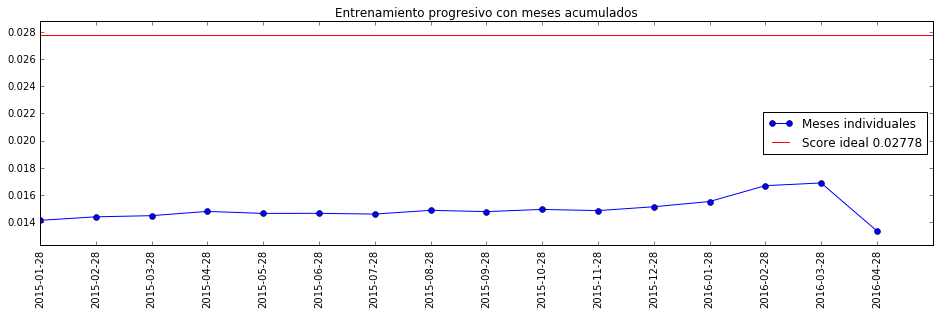

In [79]:
plt.figure(figsize=(16, 4))
plt.plot(scores_exp7, '-o')
plt.axhline(max_score[0], color='r', )
plt.ylim(scores_exp7.min() - 0.001, max_score[0]+0.001)
plt.xticks(range(len(dates_exp6)), dates_exp7, rotation=90)
plt.title('Entrenamiento progresivo con meses acumulados')
plt.legend(['Meses individuales', 'Score ideal ' + '{:.5f}'.format(max_score[0])], loc=0)

### Comparación entre los dos experimentos anteriores 

In [75]:
max_index6 = list(reversed(scores_exp6.argsort()))[0]
max_score6 = scores_exp6[max_index6]
max_index7 = list(reversed(scores_exp7.argsort()))[0]
max_score7 = scores_exp7[max_index7]

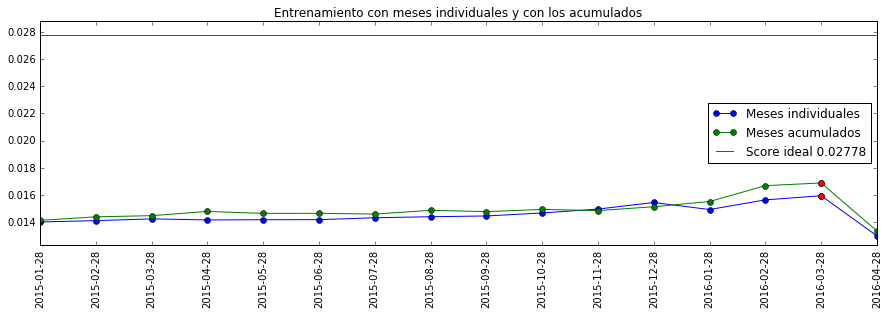

In [78]:
plt.figure(figsize=(15, 4))
plt.plot(scores_exp6, '-o', scores_exp7, '-o')
plt.axhline(max_score[0], color='r')
plt.xticks(range(len(dates_exp7)), dates_exp7, rotation=90)
plt.ylim(np.min(scores_exp7.min(), scores_exp6.min()) - 0.001, max_score[0] + 0.001)
plt.title('Entrenamiento con meses individuales y con los acumulados')
plt.legend(['Meses individuales', 'Meses acumulados', 'Score ideal ' + '{:.5f}'.format(max_score[0])], loc=0)
plt.plot(max_index6, max_score6, 'o', max_index7, max_score7, 'or')

In [83]:
print('Máximos scores logrados')
print('Score de experimento 6: {:<15.5f} Equivale al {:.2f}% del score ideal'.format(max_score6,
                                                                                     (max_score6/max_score[0])*100))
print('Score de experimento 7: {:<15.5f} Equivale al {:.2f}% del score ideal'.format(max_score7,
                                                                                     (max_score7/max_score[0])*100))

Máximos scores logrados
Score de experimento 6: 0.01593         Equivale al 57.34% del score ideal
Score de experimento 7: 0.01687         Equivale al 60.73% del score ideal


In [84]:
res_exp7.tail()

,date_start,date_end,score,amount_data
11,2015-01-28,2015-12-28,0.015120,7286293.0
12,2015-01-28,2016-01-28,0.015506,7989676.0
13,2015-01-28,2016-02-28,0.016674,8692206.0
14,2015-01-28,2016-03-28,0.016873,9393926.0
15,2015-01-28,2016-04-28,0.013334,10094948.0


### Experimento 8
Entrenamiento con sólo el mes de Abril 2016
* **Test:** Junio 2016
* **Env:** submit

In [ ]:
%%time
date = dates[-3]
df_x = df[df['fecha_dato'] == date]
df_y = df_targets.loc[df_x.index]

x_train = df_x.drop(['fecha_dato', 'fecha_alta'], axis=1).as_matrix()
y_train = df_y.as_matrix()

df_x_test = df_test.drop(['fecha_dato', 'fecha_alta'], axis=1)

x_test = df_x_test.as_matrix()

model = local.model(x_train, y_train, RandomForestClassifier(n_jobs=4))
probs, preds = local.calculatePredsProbs(x_test, model)

df_prev = df[df['fecha_dato'] == dates[-2]]

df_subm = local.processPredictions(probs, preds, df_prev, df_x_test, df_y, env='submit')

CPU times: user 5min 42s, sys: 15.9 s, total: 5min 58s
Wall time: 2min 51s


## EXPERIMENTO APLAZADO
### Experimento 9 
Entrenamiento con Mayo 2016 agregando los productos que tiene el cliente, ese mes, como *features*, además sólo irán los clientes antiguos

In [130]:
df_train = df[df['fecha_dato'] == dates[-1]]

ncodpers_both_months = list(set(df_train.loc[:, 'ncodpers'].values) & set(df_test.loc[:, 'ncodpers'].values))

In [131]:
index_prods = df_train[df_train['ncodpers'].isin(ncodpers_both_months)].sort_values(['ncodpers']).index
prods = df_train.loc[index_prods, ['ncodpers']].join(df_targets.loc[index_prods, :])
df_train = df_train[df_train['ncodpers'].isin(ncodpers_both_months)].sort_values(['ncodpers'])

In [132]:
df_train = df_train.merge(prods, on='ncodpers', how='outer', left_index=True)
df_train.head()

,fecha_dato,fecha_dato_year,fecha_dato_month,fecha_dato_day,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
10351236,2016-05-28,2016,2,28,15889,3,1,1,56,1995-01-16,...,0,0,0,0,1,1,0,0.0,0.0,0
10351235,2016-05-28,2016,2,28,15890,1,1,1,63,1995-01-16,...,0,1,0,0,1,0,0,1.0,1.0,1
10351234,2016-05-28,2016,2,28,15892,3,1,1,62,1995-01-16,...,0,0,0,1,1,1,0,0.0,0.0,1
10351233,2016-05-28,2016,2,28,15893,1,1,1,63,1997-10-03,...,0,0,0,0,0,1,0,0.0,0.0,0
10351232,2016-05-28,2016,2,28,15894,1,1,1,60,1995-01-16,...,0,0,0,1,1,1,0,1.0,1.0,1


In [136]:
%%time
df_x = df_train
df_y = df_targets.loc[df_x.index]

x_train = df_x.drop(['fecha_dato', 'fecha_alta'], axis=1).as_matrix()
y_train = df_y.as_matrix()

df_x_test = df_test.drop(['fecha_dato', 'fecha_alta'], axis=1)
model = local.model(x_train, y_train, RandomForestClassifier(n_jobs=4))

x_test = df_x_test.as_matrix()
probs, preds = local.calculatePredsProbs(x_test, model)

df_prev = df[df['fecha_dato'] == dates[-1]]
df_subm = local.processPredictions(probs, preds, df_prev, df_x_test, df_y, env='submit')

ValueError: Number of features of the model must  match the input. Model n_features is 50 and  input n_features is 26 